<a href="https://colab.research.google.com/github/kapitan05/Golem_Homework/blob/main/regression_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praca domowa - regresja

Twoim zadaniem jest przewidywanie jakości wina na podstawie różnych właściwości - pH, zawartość alkoholu, chlorków etc.
Targetem jest kolumna "quality", która przyjmuje pięć wartości: 3, 4, 5, 6, 7, 8. Możliwe, że Twoje rozwiązanie będzie miało lepszy wynik jeśli będziesz zaokrąglać wyniki swojej predykcji.

#### Co dokładnie trzeba zrobić?

1. Poznaj swój dataset:
    - Które atrybuty są najważniejsze?
    - Czy warto [znormalizować](https://pl.wikipedia.org/wiki/Standaryzacja_(statystyka)) dane?


2. Przygotuj dane:
    - Jak podzielisz dane na testowe i treningowe?
    - Czy są wiersze/kolumny, które nie będą Ci potrzebne?
    
    
3. Napisz model:
    - Tak długo jak jest to regresja, wszystkie chwyty dozwolone! Możesz użyć makepipeline żeby złożyć parę modeli w jeden, albo spojrzeć do dokumentacji sklearn i poszukać czegoś nowego
    
    
4. Oceń model:
    - Jakie wyszło Ci MSE na zbiorze testowym? Generalniee każdy wynik na zbiorze testowym poniżej 0.5 jest całkiem niezły. Mi udało się zejść do 0.31

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, BayesianRidge, LassoLars, TweedieRegressor, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [67]:

data = pd.read_csv('https://raw.githubusercontent.com/KNSI-Golem/BootcampGeneral/main/2023/meetings/2_regression/data/winequality-red.csv', delimiter=',')

In [68]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<Axes: >

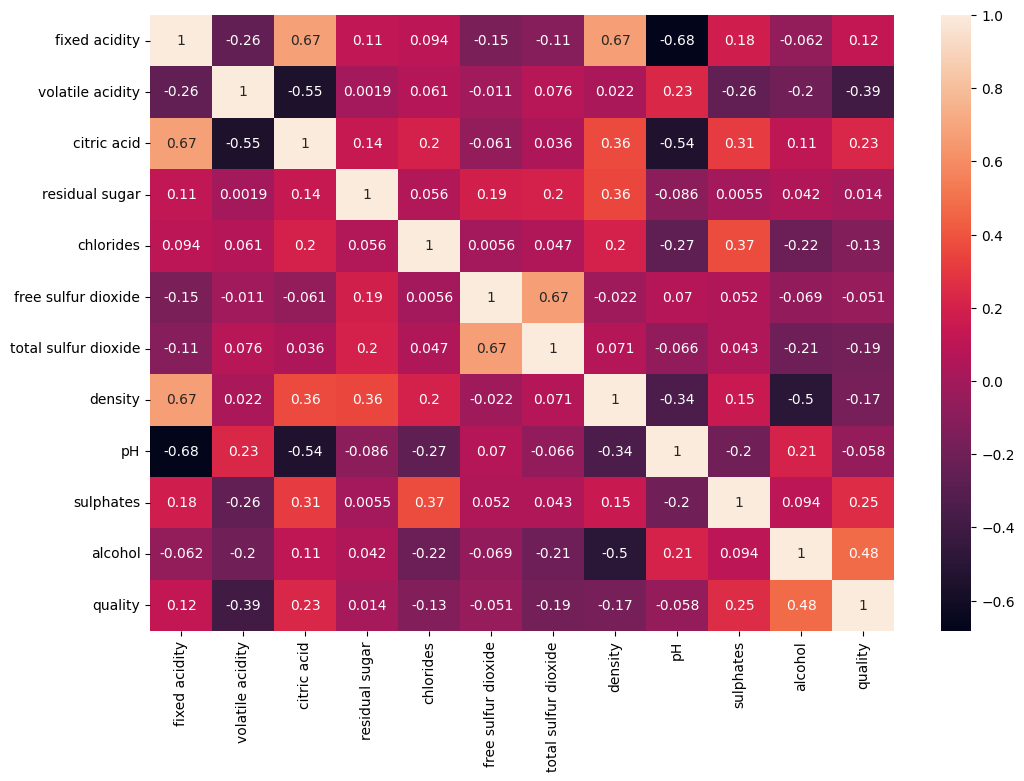

In [69]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, ax=ax)
# plt.show()

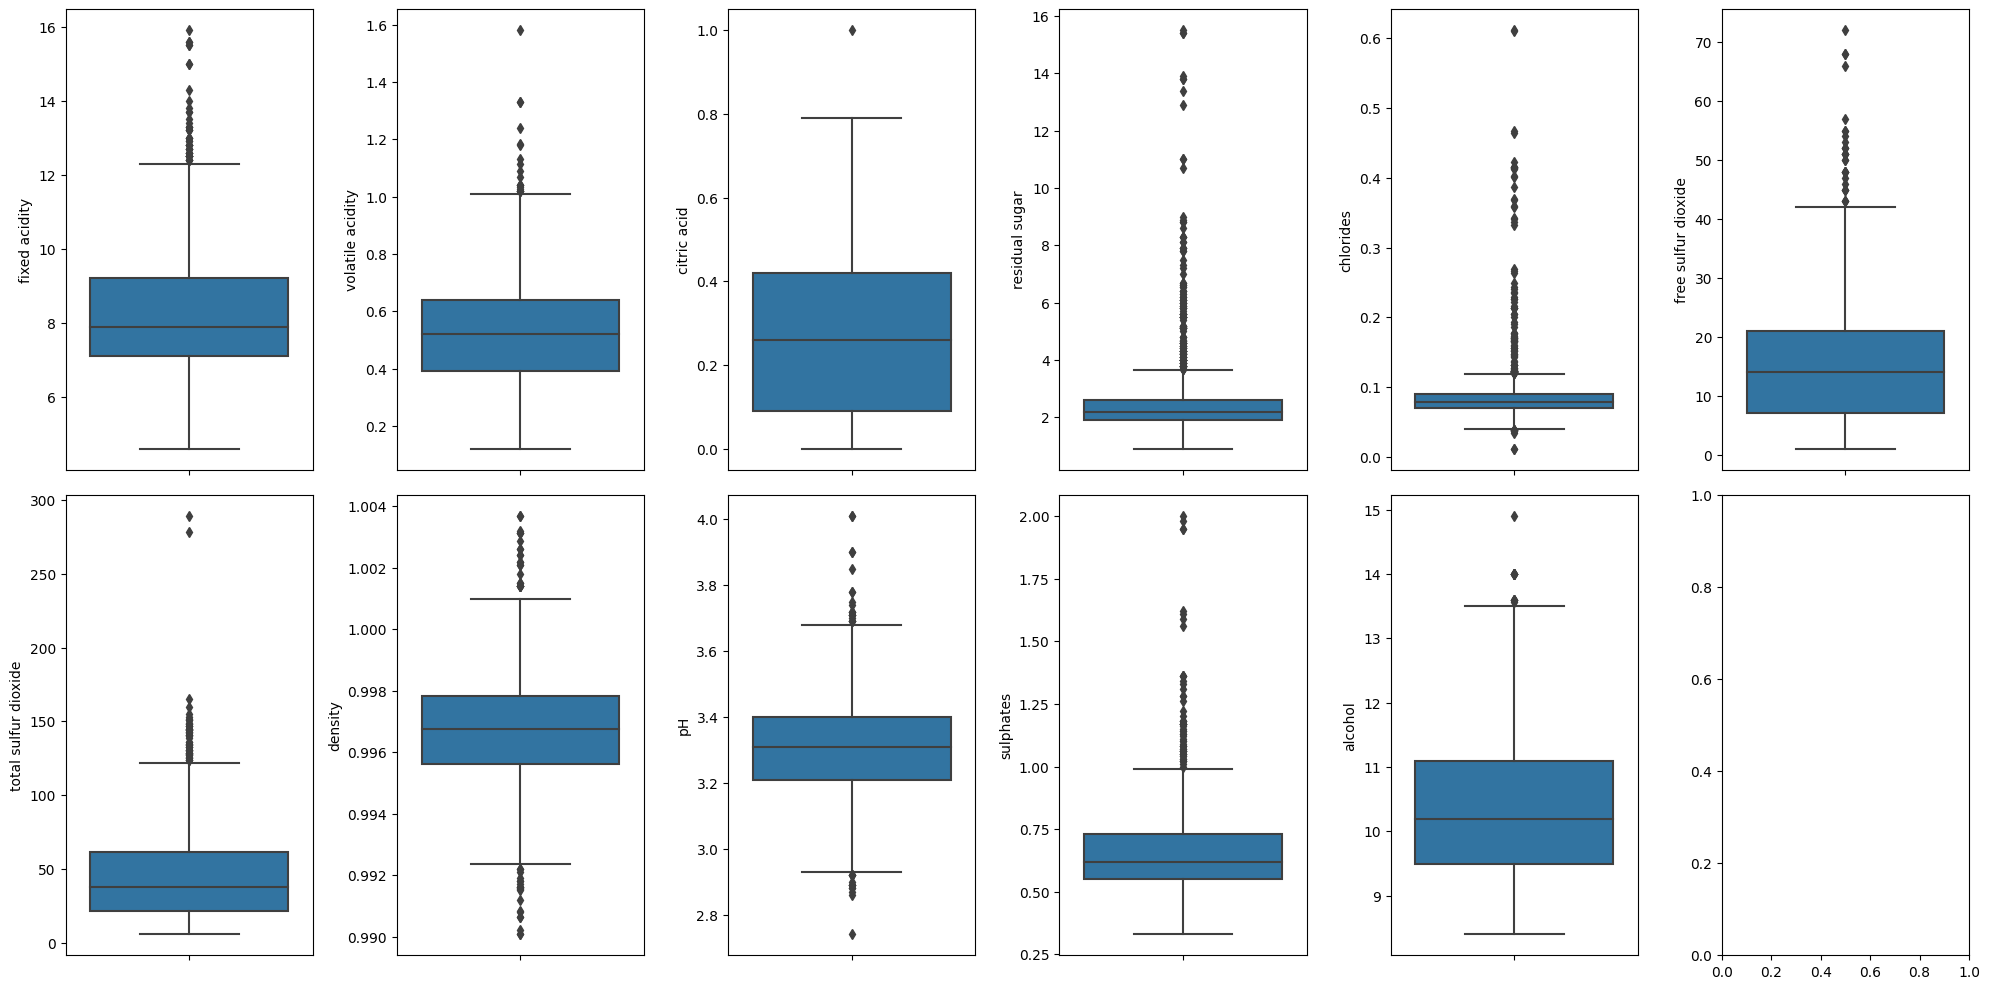

In [70]:
# dzielimy dane na target i features
target = 'quality'
features = [col for col in data.columns.to_list() if col != target]

# dla każdego feature rysujemy boxplot
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

In [71]:
# wyrzucamy outlaiery
def remove_outliers(df,columns,n_std):
    for col in columns:
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]

    return df

In [72]:
data = remove_outliers(data, features, 3)

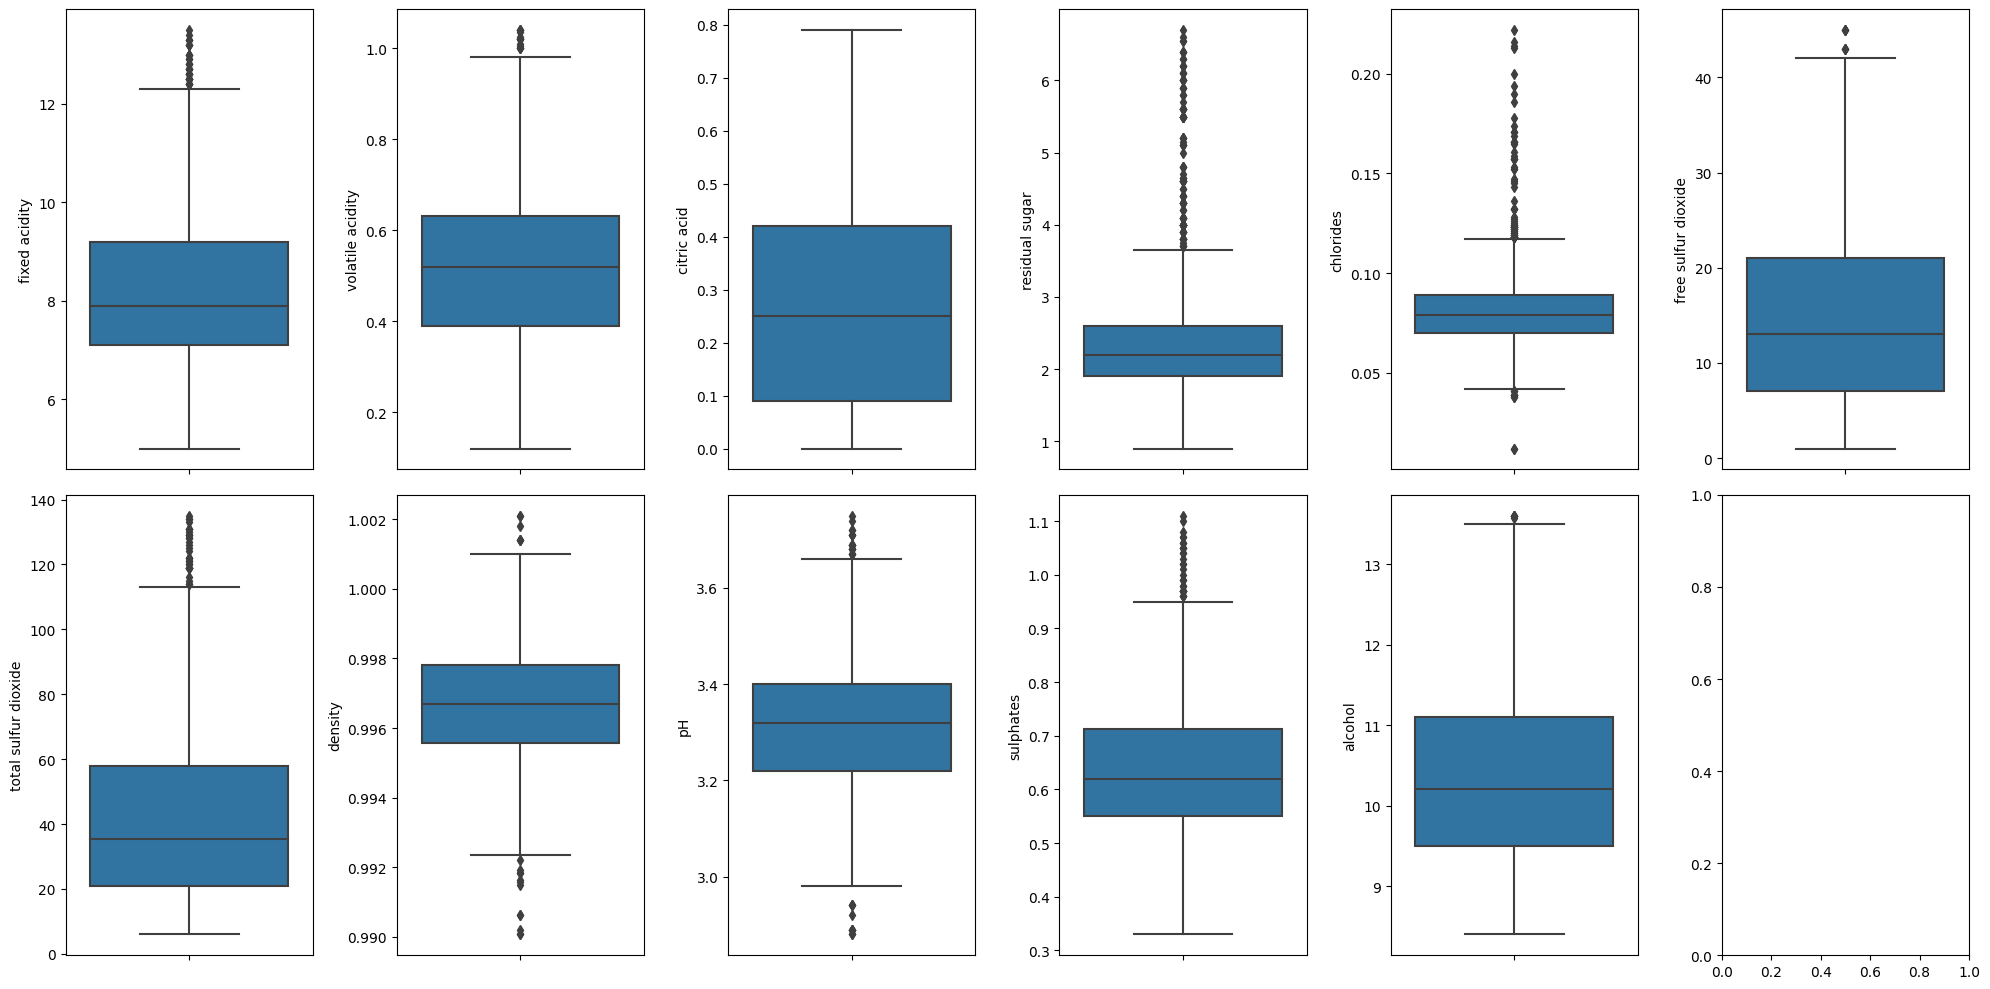

In [73]:
fig, axis = plt.subplots(2, data.shape[1]//2, figsize=[20, 10])
idx=0;
axis=axis.flatten()
for feature in features:
    sns.boxplot(y=feature, data=data[[feature]], ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

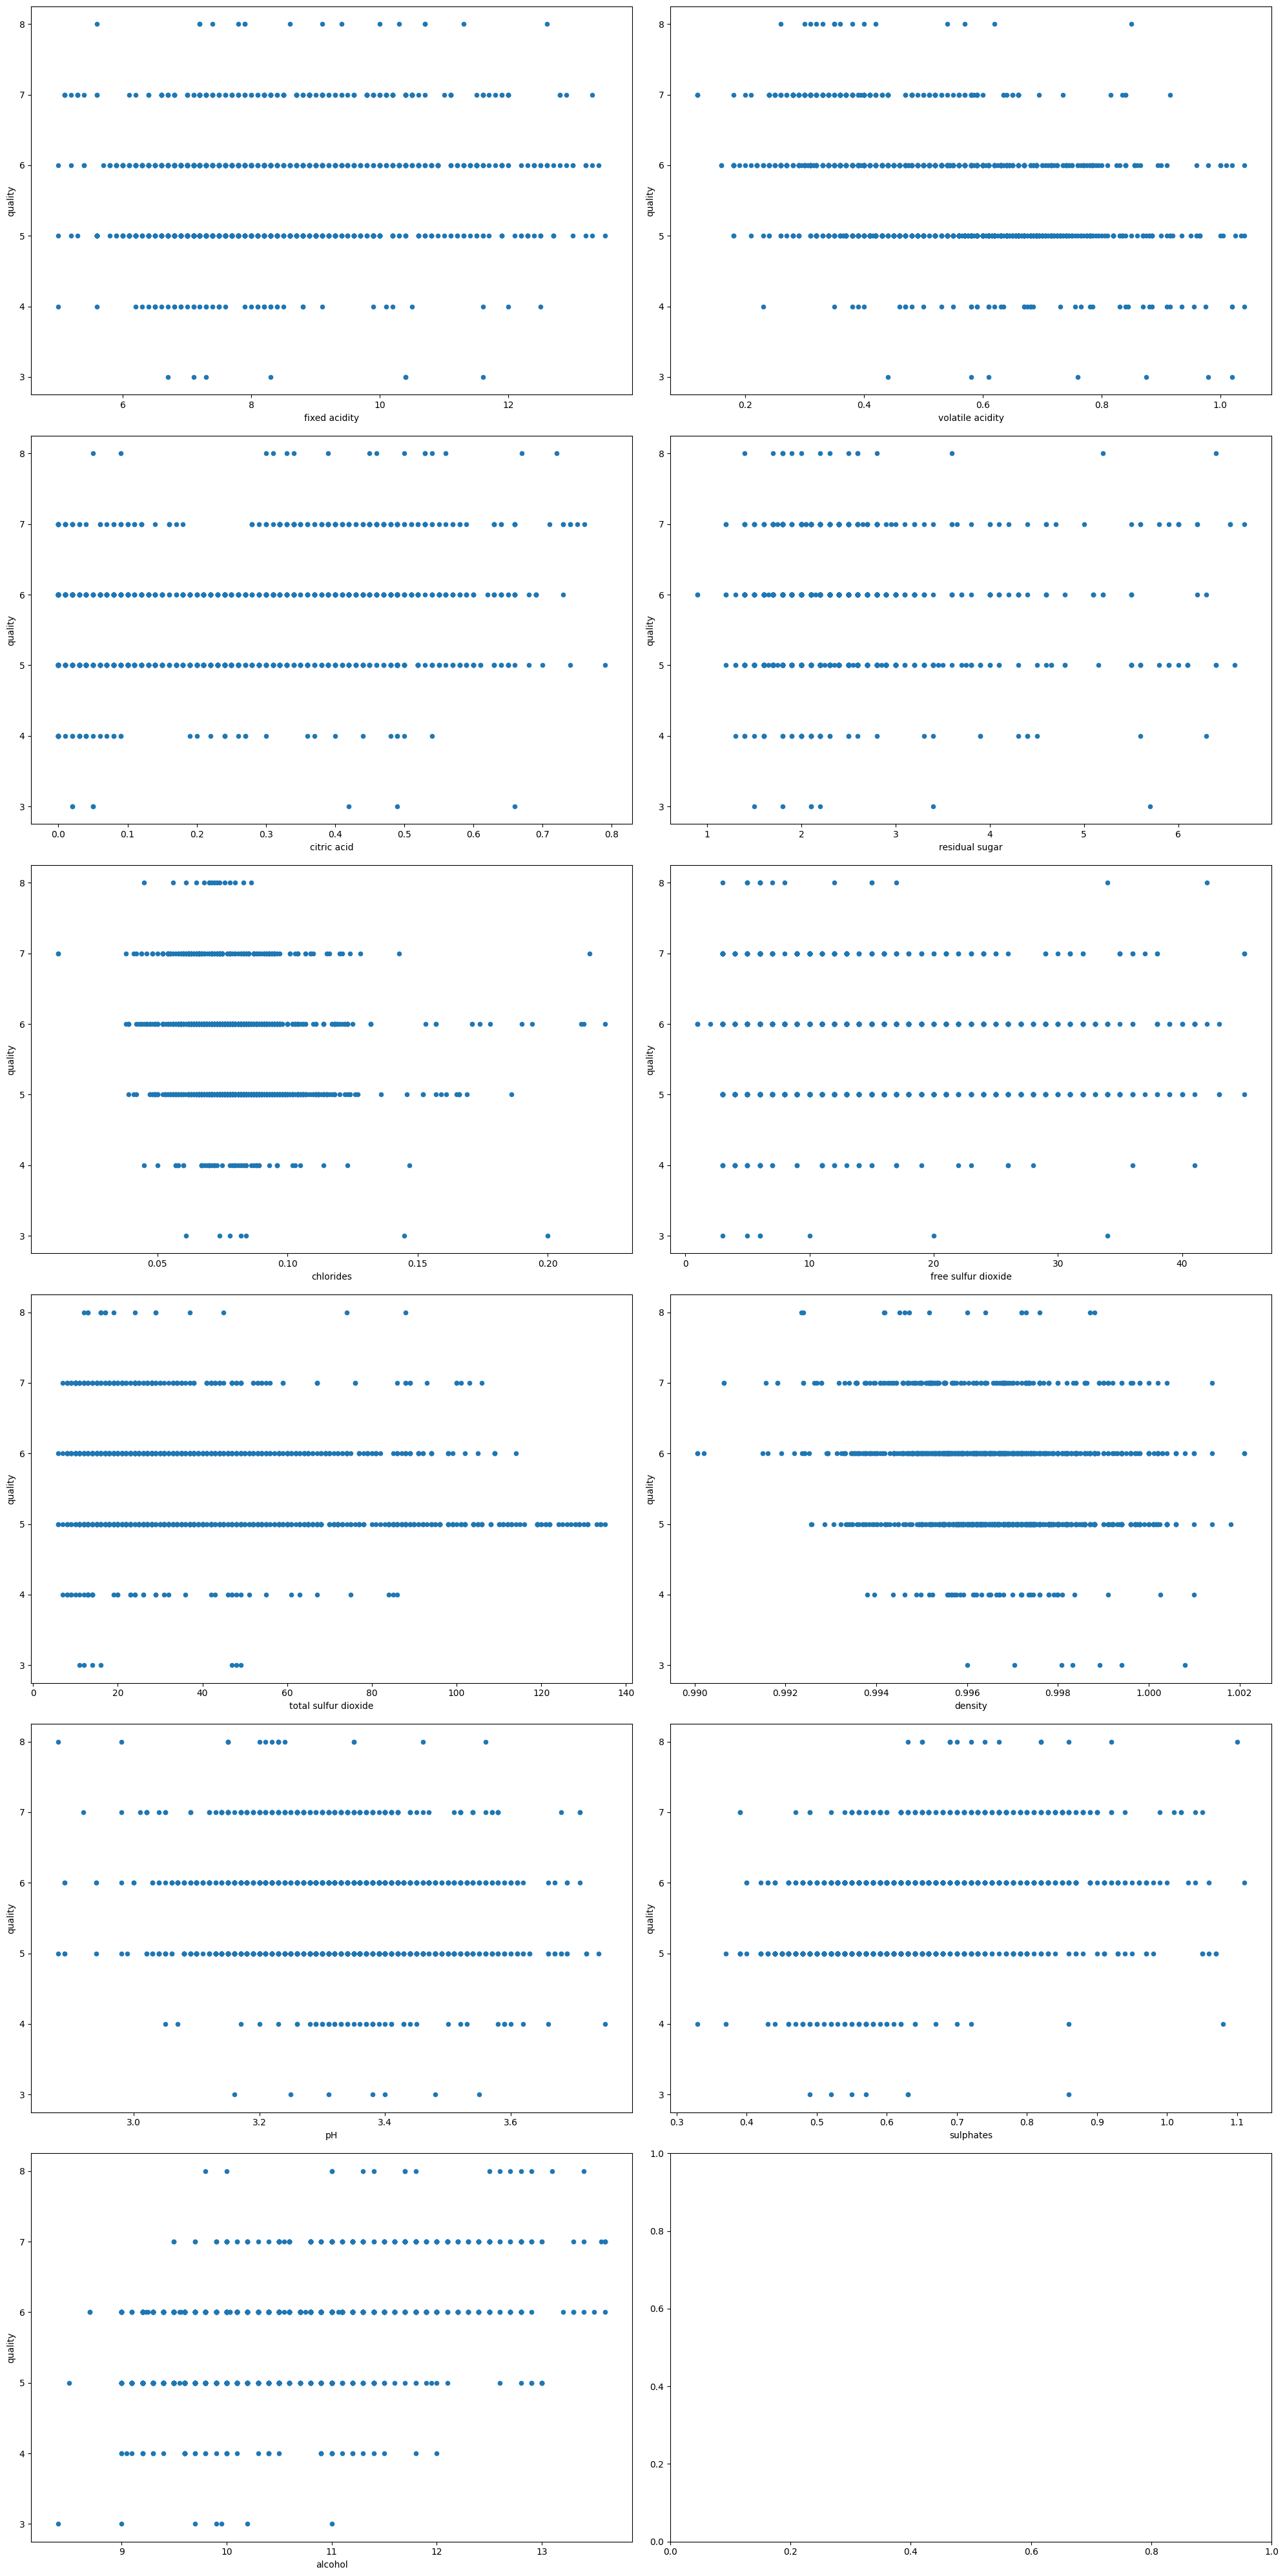

In [74]:
# dla każdej features rysujemy zależność od targetu
fig, axis = plt.subplots(data.shape[1]//2, 2, figsize=[20, 40])
idx=0;
axis=axis.flatten()
for feature in features:
    data.plot(y=target, x=feature, kind="scatter", ax=axis[idx])
    idx+=1

plt.tight_layout()
plt.show()

In [75]:
def build_model(data, model, train_test_ratio, chosen_features, target, random_state=45):

    # dzielimy na train i test
    data_train, data_test = train_test_split(data, test_size=train_test_ratio, random_state=random_state)
    X_train, X_test = data_train[chosen_features], data_test[chosen_features]
    y_train, y_test = data_train[target], data_test[target]

    # cała regresja dzieje się tutaj
    model.fit(X_train, y_train)

    # przewidujemy wartość dla danych testowych
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # liczymy MSE
    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_test = mean_squared_error(y_test, y_pred_test)
    print('MSE on training data:', MSE_train)
    print('MSE on test data:', MSE_test)

    return model, MSE_test

In [76]:
# model liniowy z jedną zmienną
chosen_features = ['alcohol']
train_test_ratio=0.2

model, MSE= build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

# tutaj robię dictionary żeby później móc porównać modele
model_dict = {"linear_1": MSE}

MSE on training data: 0.4780858201309507
MSE on test data: 0.5070955489786405


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


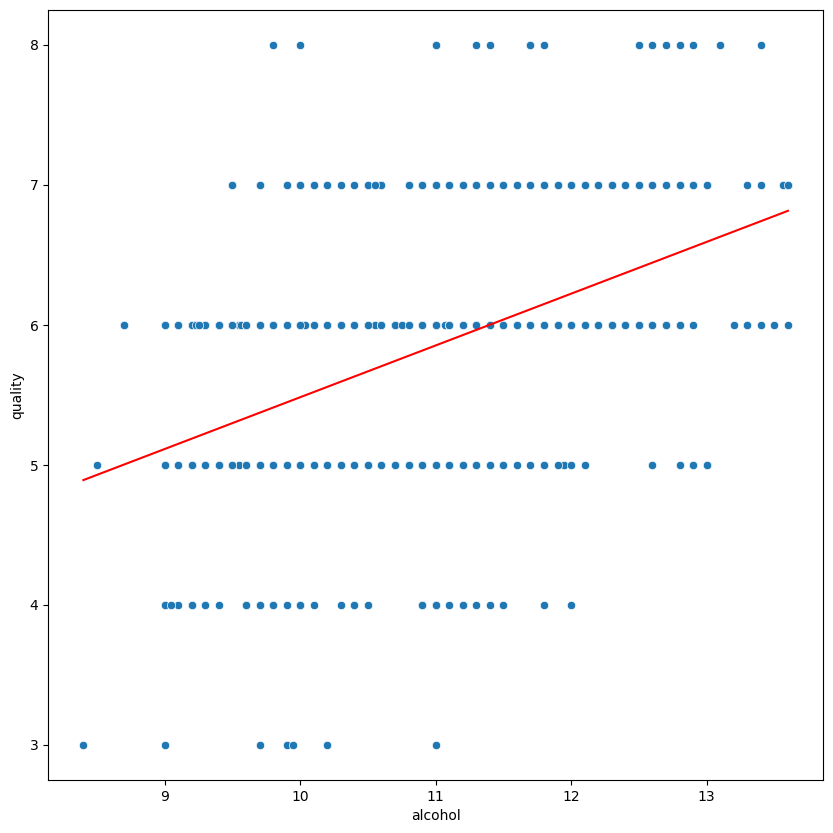

In [77]:
# można sobie zwizualizować
plt.figure(figsize=(10, 10))
sns.scatterplot(x='alcohol', y="quality", data=data[['alcohol','quality']])
tmp_x = np.array([[data['alcohol'].min(),],[data['alcohol'].max(),]])
tmp_y = model.predict(tmp_x)
plt.plot(tmp_x, tmp_y, color='r')
plt.show()

In [78]:
# model liniowy z wieloma zmiennymi
chosen_features = ['alcohol', 'sulphates', 'citric acid', 'volatile acidity']
train_test_ratio=0.2

model, MSE= build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

# tutaj robię dictionary żeby później móc porównać modele
model_dict = {"linear_2": MSE}

MSE on training data: 0.4067501830977614
MSE on test data: 0.4378339529799001


In [79]:
# model liniowy ze wszystkimi featurami

chosen_features = features

model, MSE = build_model(data, LinearRegression(), train_test_ratio, chosen_features, target)

model_dict["linear_3"] = MSE

MSE on training data: 0.39451673338600746
MSE on test data: 0.424434210684876


In [65]:
data.shape

(1440, 12)

In [80]:
degree = 2

model, MSE = build_model(data, make_pipeline(PolynomialFeatures(degree), LinearRegression()), train_test_ratio, chosen_features, target)
model_dict["linear_4"] = MSE

MSE on training data: 0.34258739685802264
MSE on test data: 0.4442495942214893


In [81]:
model, MSE = build_model(data, RandomForestRegressor(), train_test_ratio, chosen_features, target)
model_dict["radom_forest"] = MSE

MSE on training data: 0.04678532986111111
MSE on test data: 0.3248347222222222


In [82]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [83]:
## Define Grid
grid = {
    'n_estimators': [100,200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
## show start time
print(datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= 5)
CV_rfr.fit(, y_train)
## show end time
print(datetime.now())

SyntaxError: ignored

In [84]:
chosen_features = features
train, test = train_test_split(data, test_size=0.2, random_state=42)
X, Y = train[chosen_features], train[target]

In [ ]:
xgb_preds = []
rfr_preds = []
lgbm_preds = []

kf = KFold(n_splits=3, random_state=42, shuffle=True)

for i, (train_ix, test_ix) in enumerate(kf.split(data[features]))

    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

   ## XGBoost
    xgb_md = XGBRegressor().fit(X_train, Y_train)
    xgb_pred = xgb_md.predict(X_test)
    xgb_score_fold = np.sqrt(mean_squared_error(Y_test, xgb_pred))
    print('Fold', i+1, '==> XGBoost oof RMSE score is ==>', xgb_score_fold)

    xgb_pred_test = xgb_md.predict(test[chosen_features])
    xgb_preds.append(xgb_pred_test)

    ## RandomForestRegressor
    rfr_md = RandomForestRegressor().fit(X_train, Y_train)
    rfr_pred = rfc_md.predict(X_test)
    rfr_score_fold = np.sqrt(mean_squared_error(Y_test, rfr_pred))
    print('Fold', i+1, '==> XGBoost oof RMSE score is ==>', xgb_score_fold)

    rfr_pred_test = rfr_md.predict(test[chosen_features])
    rfr_preds.append(rfr_pred_test)

    ## LGBM

    lgbm_md = LGBMRegressor(n_estimators = 1000,
                        max_depth = 15,
                        learning_rate = 0.01,
                        num_leaves = 105,
                        reg_alpha = 0.1, #0.3
                        reg_lambda = 0.1,
                        subsample = 0.7,
                        colsample_bytree = 0.8).fit(X_train, Y_train)
    lgbm_pred = lgbm_md.predict(X_test)
    lgbm_score_fold = np.sqrt(mean_squared_error(Y_test, lgbm_pred))
    print('Fold', i+1, '==> LGBM oof RMSE score is ==>', lgbm_score_fold)

    lgbm_pred_test = lgbm_md.predict(test)
    lgbm_preds.append(lgbm_pred_test)



In [ ]:
model_dict

In [ ]:
heights = model_dict.values()
labels = model_dict.keys()
plt.bar(range(len(labels)), heights)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.show()